In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon
from typing import Mapping

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


def random_like(array: np.ndarray) -> np.ndarray:
    return np.random.rand(*array.shape)


In [2]:
class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()

In [3]:
class PolarCirclePlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['main_ax'] = cache.fig.add_subplot(cache.gc[:6, :], projection='polar')
        self.requires = [
            'main_ax',
            'movement_params',
            'fig'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.rotate_target is not None:
            self.main_ax.plot(
                [
                    self.movement_params.rotate_target,
                    self.movement_params.rotate_target
                ],
                [0, 1],
                marker='o'
            )
        if self.movement_params.direction is not None:
            self.main_ax.plot(
                [
                    self.movement_params.direction,
                    self.movement_params.direction
                ],
                [0, 1],
                marker='o',
                color='red'
            )

    def on_clean(self):
        self.main_ax.clear()

In [4]:
class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

In [5]:
def should_rotate_clockwise(phi1: float, phi2: float) -> bool:
    # Normalize angles to be within 0 to 2*pi radians
    phi1 = phi1 % (2 * np.pi)
    phi2 = phi2 % (2 * np.pi)

    # Calculate the difference in angles
    diff = phi2 - phi1

    # Normalize the difference to be within -pi to pi radians
    # This determines the shortest rotation direction
    if diff > np.pi:
        diff -= 2 * np.pi
    elif diff < -np.pi:
        diff += 2 * np.pi

    # If diff is positive, the shortest way is clockwise
    # If diff is negative, the shortest way is counterclockwise
    if np.isclose(diff, 0):
        return None

    return diff > 0

In [6]:
from bbtoolkit.environment import Environment
from bbtoolkit.models.bb.neural_generators import TCGenerator
from bbtoolkit.utils.datautils.configparser import EvalConfigParser


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
env = Environment.load('../data/envs/inserted_wall_environment.pkl')
# env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

In [7]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup
from bbtoolkit.structures.tensorgroups import DirectedTensor, DirectedTensorGroup

weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
n_hd_neurons = len(weights.hd.to.hd)

activity = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring1',
        weights=connectivity.hd.to.hd
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring2',
        weights=connectivity.hd.to.hd
    )
)


connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring1',
        weights=dict(phi=5)
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring2',
        weights=dict(phi=-3)
    )
)

weights = weights.operation_with(
    connectivity,
    lambda a, b: a - b.get('inhibitory_phi', 0),
    on_missing_weights='ignore',
    on_missing_sources='ignore'
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

In [8]:
connectivity.hd.to.hd

{'phi': 15, 'inhibitory_phi': 0.4, 'tau': 0.02, 'beta': 0.1, 'alpha': 5}

In [9]:
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d
from bbtoolkit.utils.math import circular_gaussian


class HDCallback(BaseCallback):
    def __init__(
        self,
        attractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = init_timesteps

        self.attractor = attractor
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache.rates.hd_ring1))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*circular_gaussian(
                self.movement_params.direction,
                len(self.rates.hd_ring1)
            )
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        if self.dynamics_params.step == 1*(500):
            speed_rule = lambda x: .6*x + 0.07875*x**2
            self.attractor.kernel = (
                self.attractor.kernel[0],
                (
                    gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                    gaussian_kernel_1d(100, center=0.8, sigma=0.15) +
                    # 0.15*gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                    speed_rule(.25)*gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                    # 4*(0.15 + 2*1.125*0.0175)*gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                    # 4*1.5*(0.15 + 1.5*2*1.125*0.0175)*gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                )[None, :]
            )
        if self.dynamics_params.step == 500 + 1*(500):
            self.attractor.kernel = (
                self.attractor.kernel[0],
                # (
                #     gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                #     gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                # )[None, :]
                (
                    gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                    gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                )[None, :]
            )

        bkg_drive   = 4*(10+2*np.random.rand(self.rates.hd_ring2.shape[0], 1))
        bkg_driveIN = 2*np.random.rand(self.rates.hd_ring1.shape[0], 1)

        state = self.attractor(self.rates.hd_ring1.T, self.rates.hd_ring2.T)
        w1, w2 = state.values()
        w1, w2 = w1.T, w2.T

        self.k_ratio.hd_ring1 = (
            - self.activity.hd_ring1
            + self.connectivity.hd_ring2.to.hd_ring1['phi']*w1
            + bkg_driveIN
            + self.hd_cue[:, None]
        )
        self.k_ratio.hd_ring2 = (
            - self.activity.hd_ring2
            + self.connectivity.hd_ring1.to.hd_ring2['phi']*w2
            + bkg_drive
        )

        self.activity.hd_ring1 += self.dt/.02*self.k_ratio.hd_ring1
        self.activity.hd_ring2 += self.dt/.02*self.k_ratio.hd_ring2

        self.rates.hd_ring1 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring1 - 30)))
        self.rates.hd_ring2 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring2 - 30)))

        if self.total_steps == 0:
            popmax = np.where(self.rates.hd_ring1 == np.max(self.rates.hd_ring1))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd_ring1) - 1) % (2*np.pi)
            self.movement_params.direction = hd_estim




In [10]:
import matplotlib.pyplot as plt
from typing import List, Optional
import numpy as np
import matplotlib.axes

def plot_columns_of_dots(
    vals: list[float],
    ax: Optional[matplotlib.axes.Axes] = None,
    **kwagrs
) -> plt.Figure:
    """
    Plots a vector of values as columns of dots on a scatter plot.

    Parameters:
    - vals: List[float]. A vector of values to be plotted as columns of dots.
    - ax: Optional[matplotlib.axes.Axes]. A matplotlib Axes object to plot on. If None, uses the current Axes.
    - **kwagrs: Optional. Additional keyword arguments to pass to the scatter plot function.

    Returns:
    - None
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Determine the spacing between dots in the column
    dot_spacing = 0.1

    # Generate the scatter plot data
    x_positions = []
    y_positions = []
    for idx, val in enumerate(vals):
        for i in np.arange(0, val, dot_spacing):
            x_positions.append(idx)
            y_positions.append(i)

    ax.scatter(x_positions, y_positions, **kwagrs)

    # Optionally, customize the plot with titles and labels
    return fig

In [11]:
class HDPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[6:8, :])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[8:10, :])
        cache['hd_ax_3'] = cache.fig.add_subplot(cache.gc[10:, :])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'hd_ax_3',
            'fig',
            'rates',
            'weights',
            'activity',
            'k_ratio',
            'movement_params',
            # 'hd_attractors'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        self.hd_ax_1.plot(
            self.rates.hd_ring1,
            '-'
        )
        self.hd_ax_2.plot(
            self.rates.hd_ring2,
            '-'
        )
        # rot_weights = None
        # target = self.movement_params.rotate_target
        # direction = self.movement_params.direction
        # rotation = np.zeros_like(self.rates.hd)

        # if target is not None:
        #     angle_to_target = target

        #     diff = angle_to_target - direction
        #     if diff > np.pi:
        #         diff -= 2*np.pi
        #     elif diff < -np.pi:
        #         diff += 2*np.pi

        #     if np.isclose(diff, 0, atol=0.05):
        #         rotation = np.zeros_like(self.rates.hd)
        #     elif diff < 0:
        #         rotation = (self.hd_attractors.cw_rotation(self.rates.hd.T)@self.rates.hd.T).T
        #     elif diff > 0:
        #         rotation = (self.hd_attractors.ccw_rotation(self.rates.hd.T)@self.rates.hd.T).T

        # if rot_weights is None:
        #     rot_weights = np.zeros_like(self.weights.rot.to.rot)

        # self.hd_ax_1.plot(self.rates.hd)
        # self.hd_ax_2.plot((self.hd_attractors.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T)
        # self.hd_ax_3.plot(rotation)

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_1.set_ylim(0, 1)
        self.hd_ax_2.clear()
        self.hd_ax_2.set_ylim(0, 1)
        self.hd_ax_3.clear()

In [12]:
from typing import Literal, Mapping


class RotationCallback(BaseCallback):
    def __init__(
        self,
        rotation_speed: float
    ):
        super().__init__()
        self.rotation_speed = rotation_speed

    def set_cache(self, cache: Mapping, on_repeat: Literal['raise'] | Literal['ignore'] | Literal['overwrite'] = 'raise'):
        self.requires = [
            'movement_params',
        ]
        super().set_cache(cache, on_repeat)

    def on_step_begin(self, step: int):
        if self.movement_params.direction is not None and\
            self.movement_params.rotate_target is not None:
            if self.movement_params.direction != self.movement_params.rotate_target:
                diff = self.movement_params.rotate_target - self.movement_params.direction
                if diff > np.pi:
                    diff -= 2*np.pi
                elif diff < -np.pi:
                    diff += 2*np.pi

                if np.isclose(diff, 0, atol=0.05):
                    self.movement_params.rotate_target = self.movement_params.direction
                elif diff < 0:
                    self.movement_params.direction -= self.rotation_speed
                elif diff > 0:
                    self.movement_params.direction += self.rotation_speed

                self.movement_params.direction %= 2*np.pi

2024-06-11 17:50:13 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-11 17:50:13 - DEBUG - Loaded backend inline version unknown.
2024-06-11 17:50:13 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-11 17:50:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2024-06-11 17:50:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-06-11 17:50:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.

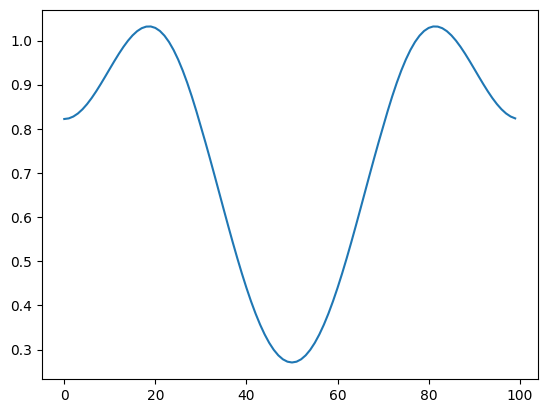

In [ ]:
%matplotlib inline
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d


ker = (
    (
        gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
        gaussian_kernel_1d(100, center=0.8, sigma=0.15)
    )
)
plt.plot(ker)

2024-06-11 17:50:15 - DEBUG - Loaded backend inline version unknown.


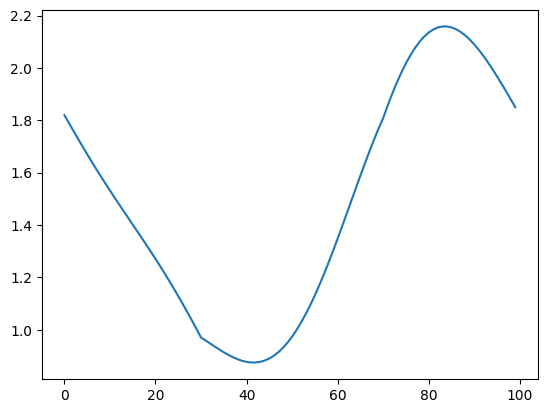

In [ ]:
%matplotlib inline
plt.plot((
    gaussian_kernel_1d(100, center=0.2, sigma=0.2) +
    2*gaussian_kernel_1d(100, center=0.8, sigma=0.2)
))

In [14]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters
from bbtoolkit.structures.attractors import RingAttractor
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d

%matplotlib qt

dt = .002

direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=np.pi/2)
cache['weights'] = weights.copy()
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
cache.connectivity.hd_ring1.to.hd_ring2['phi'] = -3
cache.connectivity.hd_ring2.to.hd_ring1['phi'] = 10


dynamics = DynamicsManager(
    dt,
    callbacks=[
        RotationCallback(np.pi/500),
        HDCallback(
            RingAttractor(
                (
                    gaussian_kernel_1d(100, center=0.5, sigma=0.05)[None, :],
                    # (gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                    # gaussian_kernel_1d(100, center=0.8, sigma=0.15))[None, :]
                    (
                        gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                        gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                    )[None, :]
                )
            ),
            60
        ),
        TimerCallback(),
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                # RotSpeedPlotter((0, 0), 0.0000001),
                HDPlotter(),
                MouseEventCallback(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

ImportError: cannot import name 'RingAttractor' from 'bbtoolkit.structures.attractors' (/home/user/Projects/SpatialMemory/bbtoolkit/structures/attractors/__init__.py)